**Some words...**

This investigation was conducted in an endeavor to identify trading patterns that could subsequently be employed within the trading system.

**Dataset**

- The dataset has been generated by the Freqai trading bot.
- It comprises a trading pair dataset for ADA/USDT, which also includes BTC/USDT features.
- All features exhibit a shift of 5 ticks, meaning each sample encompasses values from the past 5 minutes.
- All features are scaled using the MinMaxScaler within the range of -1 to 1.
- Among the features are RSI, BB bounds, raw prices, and percentage change per tick.
- Certain features are observed over 15-minute and 1-hour periods.
- The target variable represents the change in price per tick (minute), where a value of -0.01 denotes a 1% decrease.

**Attempted Approaches**

- Model tuning did not yield any significant results, with performance improvements of less than 1% compared to the default parameters.
- Adjusting the prediction horizon and timeframe resulted in increased root mean square error (RMSE), indicating even poorer predictions.
- Additional feature selection and removal also failed to provide valuable outcomes, with RMSE changes of only 1%.
- Attempts were made to predict the BTC/USDT pair exclusively, but performance remained consistent.
- Sample weighting was explored, prioritizing strong signals, which led to decreased RMSE. However, analyzing the residual plot revealed that although rare samples performed better in the training set, there was no noticeable improvement in the test set performance.
- Outliers (samples with a standard deviation greater than 3) were both removed and included, but they had no impact on the test and train sets.

**Conclusions**

No practical applications for live trading were identified. The model was unable to detect patterns in the training set that would yield predictions better than the mean of the test set.

**Ideas**

Residual plots in the training set indicate that predictions greater than 0.1 and less than -0.1 are likely to indicate a change in direction. Further analysis should be conducted to explore the reasons behind these occurrences and determine if they can be utilized in any way.

# Imports

In [1]:
import joblib
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import warnings
from denseweight import DenseWeight
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")
xgb.set_config(verbosity=1)


# Declare dataset paths

In [2]:
models_path = "../models"
name = '1m_label-1_shift-5_periods-1-BTC'
number = 2
symbol = 'ADA'
lowed_symbol = symbol.lower()
code = "1672876800"
model_dir_path = models_path + f"/{name}-{number}/sub-train-{symbol}_{code}"
metadata_path = model_dir_path + f"/cb_{lowed_symbol}_{code}_metadata.json"
features_path = model_dir_path + f"/cb_{lowed_symbol}_{code}_trained_df.pkl"
labels_path = model_dir_path + f"/cb_{lowed_symbol}_{code}_trained_labels_df.pkl"
model_path = model_dir_path + f"/cb_{lowed_symbol}_{code}_model.joblib"


# Load dataset

In [3]:
def load_metadata():
    global metadata_path
    with open(metadata_path, "r") as f:
        return json.load(f)


def load_ds():
    global features_path, labels_path
    with open(features_path, "rb") as f:
        X = pickle.load(f)

    with open(labels_path, "rb") as f:
        Y = pickle.load(f)

    return X, Y


def load_model():
    return joblib.load(model_path)


In [4]:
metadata = load_metadata()
X, Y = load_ds()
label_keys = Y.keys().tolist()
model = load_model()


# Prepare Dataset

In [ ]:
def revert_scale(values, min_value, max_value):
    values_clone = values.copy()
    return min_value + (values_clone + 1.0) * 0.5 * (max_value - min_value)

def revert(values):
    return revert_scale(values, metadata["&-s_close_min"], metadata["&-s_close_max"])

def rescale(Y):
    return 2 * (Y - Y.min()) / (Y.max() - Y.min()) - 1

def get_indexes_wo_outliers(df, column, std=3):
    return df[abs((df[column].mean() - df[column] ) / df[column].std()) < std].index

def filterout_by_std(X, Y, std):
    indexes = get_indexes_wo_outliers(Y, '&-s_close', std)
    reverted = revert(Y)
    filtered_reverted = reverted.loc[indexes]

    rescaled = rescale(filtered_reverted)

    return X.loc[indexes], rescaled

train_X, train_Y =  filterout_by_std(X, Y, 3)

# Remove features

In [ ]:
# filter out columns that have shift
def filter_out_columns(train_X, column):
    columns_to_filterout = train_X.filter(regex=column).columns.tolist()
    columns_wo_shift = train_X.columns[~train_X.columns.isin(columns_to_filterout)].tolist()
    train_X = train_X[columns_wo_shift]
    return train_X


def filter():
    train_X = filter_out_columns(train_X, "sma")
    train_X = filter_out_columns(train_X, "ema")
    train_X = filter_out_columns(train_X, "raw")
    train_X = filter_out_columns(train_X, "shift")


In [ ]:
# X = filter_out_columns(X, "shift")

# Sample weighting

In [ ]:
def get_weights(labels, alpha=1):
    dw = DenseWeight(alpha=alpha)
    dw.fit(labels)
    counts, bins = np.histogram(labels, bins=100)

    def func(v):
        return pow(v, 7)

    density = func(dw.eval(bins))
    return func(dw.weights)

In [ ]:
def plot_datasets(X):
    for column in X.columns:
        plt.title(column)
        plt.hist(X[column], bins=100)
        plt.show()

# Init model & dataset split

In [ ]:
def get_model(alpha, std):
    global X, Y

    params = {
        "max_depth": 10,
        "learning_rate": 0.07109375514004197,
        "n_estimators": 10000,
        "min_child_weight": 17,
        "gamma": 0.0022487781882634316,
        "subsample": 0.790320036578317,
        "colsample_bytree": 0.9940781270525615,
        "reg_alpha": 4.573097358976904e-06,
        "reg_lambda": 7.186304012143283e-07
    }

    train_X, train_Y =  filterout_by_std(X, Y, std)
    weights = get_weights(train_Y["&-s_close"].values, alpha=alpha)

    X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
        train_X, train_Y, weights, test_size=0.1, random_state=10, shuffle=False
    )

    model = XGBRegressor(tree_method = "gpu_hist", **params)
    model.fit(
        X_train,
        y_train,
        sample_weight=train_weights,
        eval_set=[(X_test, y_test)],
        sample_weight_eval_set=[(test_weights)],
        early_stopping_rounds=5,
        verbose=True,
    )

    predictions = model.predict(X_test)

    print('R2', r2_score(y_test["&-s_close"], predictions, sample_weight = test_weights))

    return model, X_train, y_train, X_test, y_test 

In [ ]:
model, X_train, y_train, X_test, y_test = get_model(0, 10)

# Plot residual charts

In [20]:
%matplotlib ipympl

def residual_plot(model, X, y, column = None):
    predictions = model.predict(X)
    residuals = (y["&-s_close"] - predictions)
    mean = y['&-s_close'].mean()
    critical_line = np.linspace(-1, 1, 100)

    x_line = y['&-s_close'] if column == None else X[column]

    plt.close()
    plt.figure(figsize=(17, 10))
    sns.scatterplot(x=x_line, y=residuals, s=1)
    plt.plot(critical_line + mean, critical_line, color="red")
    plt.vlines(mean, -1, 1, color="grey")
    plt.show()

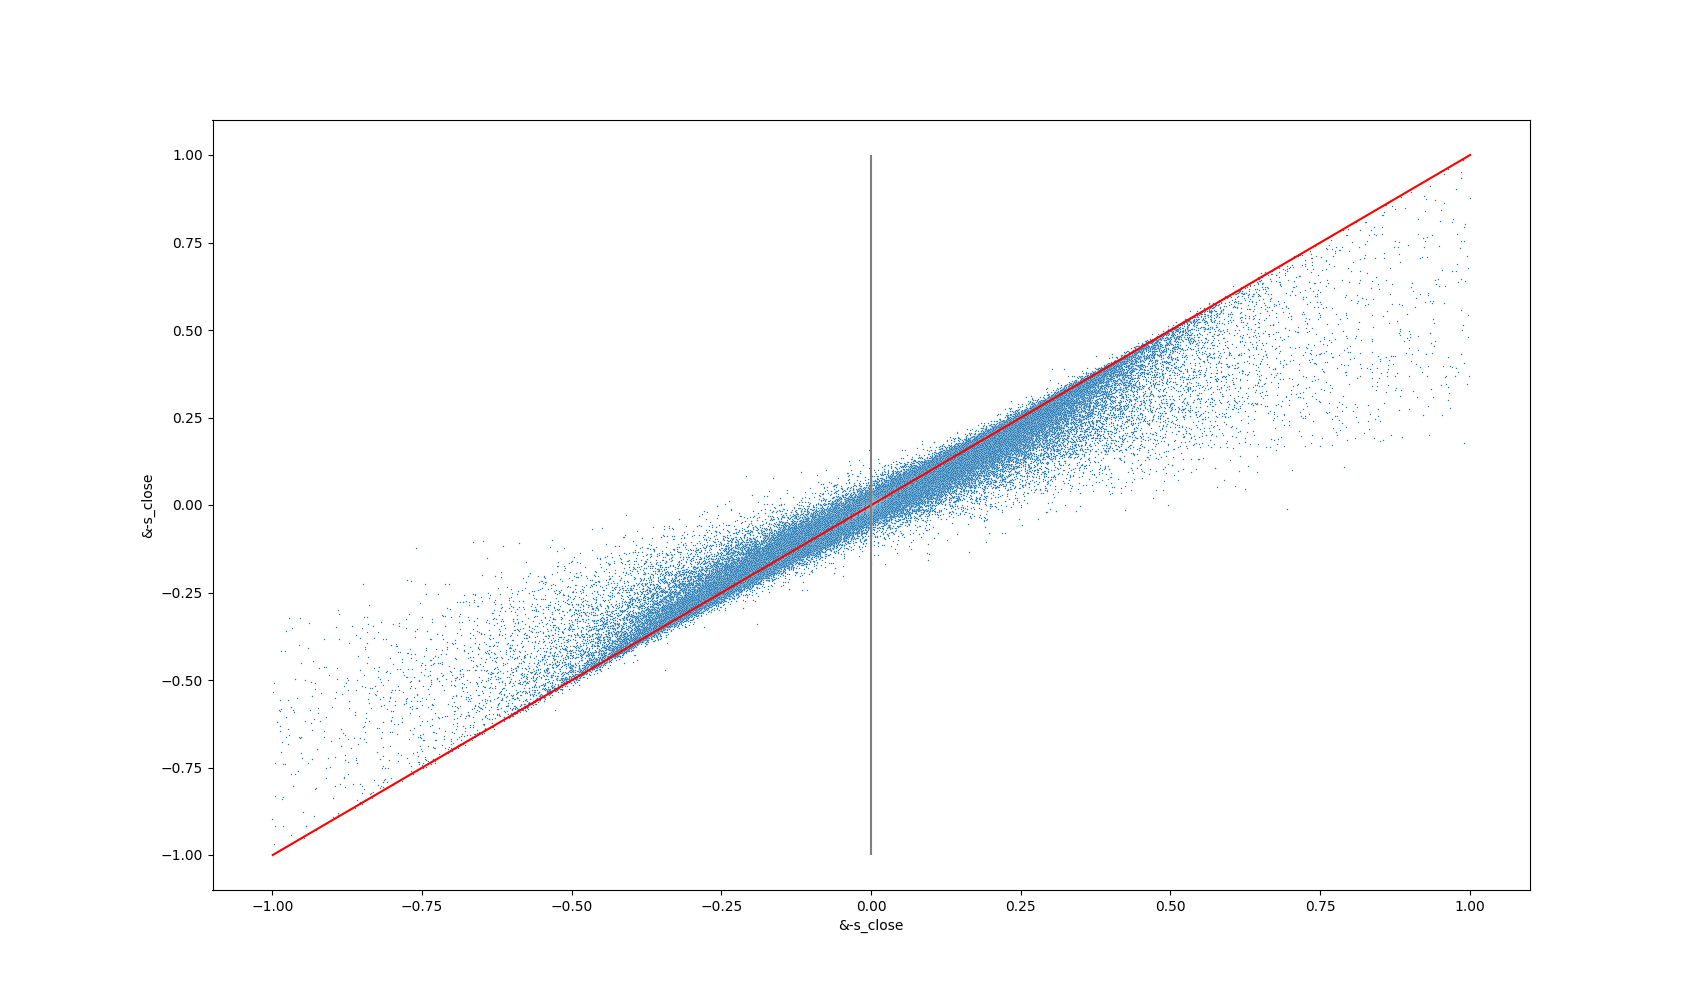

In [23]:
residual_plot(model, X_train, y_train)

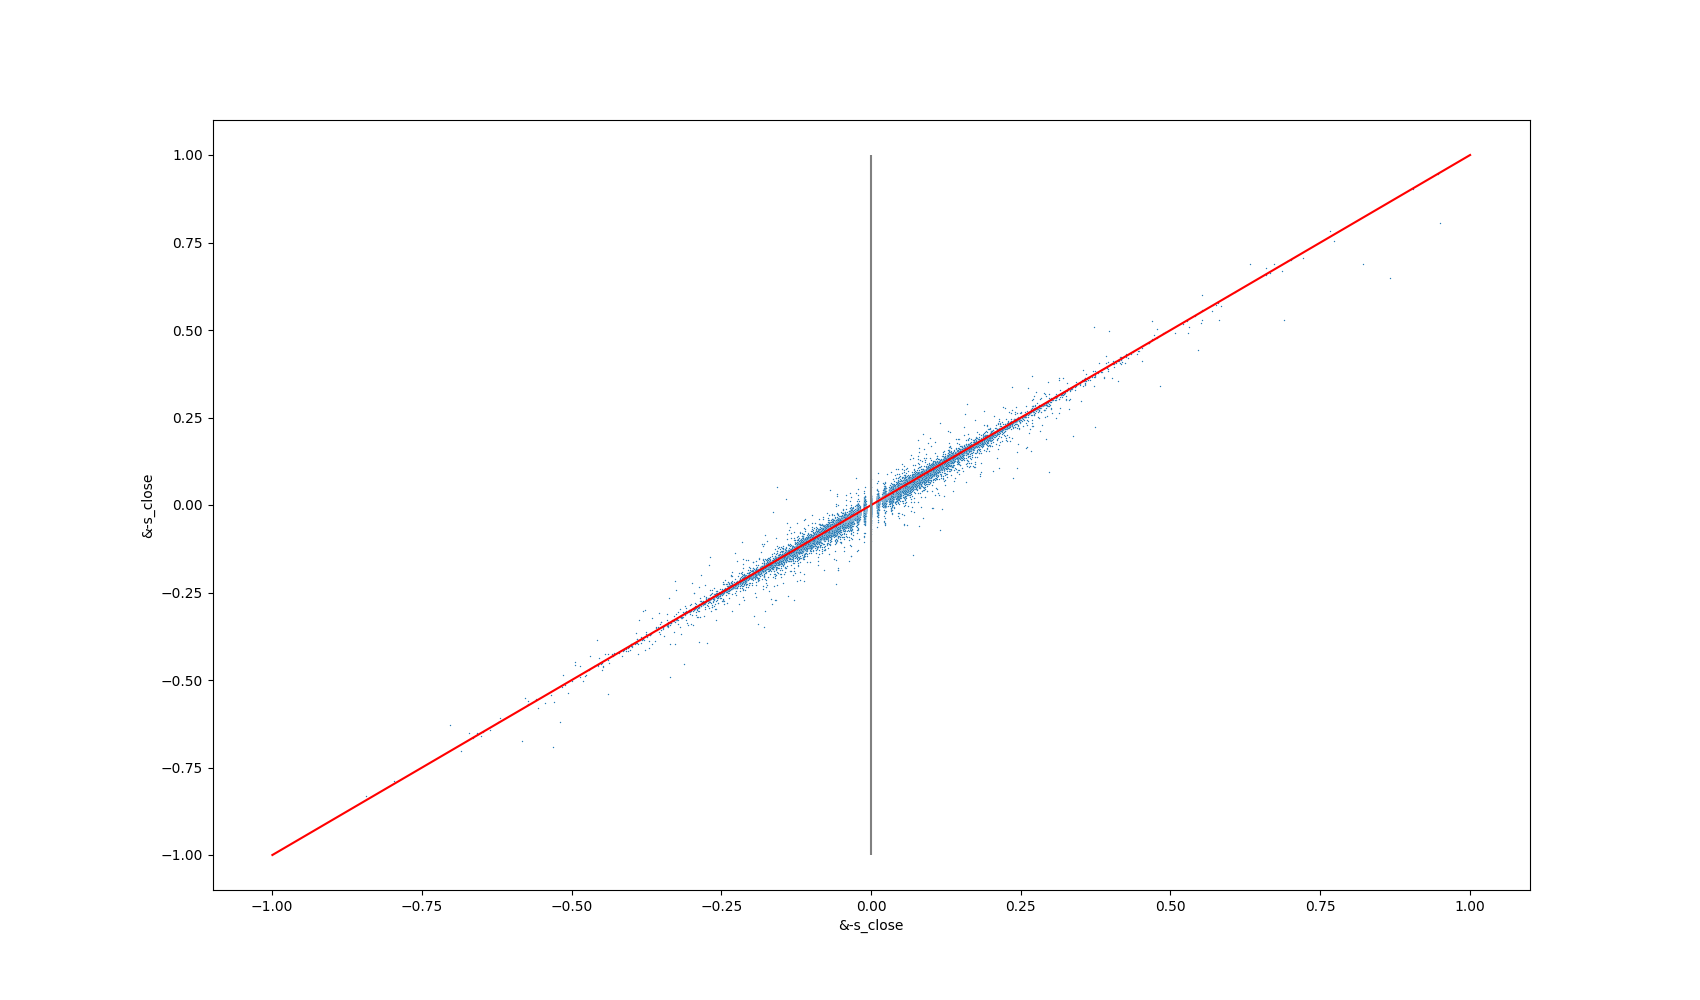

No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm: fd6890424b814244825134fe58f1add0
No such comm:

In [22]:
residual_plot(model, X_test, y_test)

# Analize best predictions

In [ ]:
predictions = model.predict(X_train)

In [ ]:
left_side_indexes = predictions < -0.1
right_side_indexes = predictions > 0.1
best_X = X_train[left_side_indexes | right_side_indexes]
best_Y = y_train[left_side_indexes | right_side_indexes]

In [ ]:
%matplotlib inline

for column in best_X.columns:
    plt.title(column)
    plt.hist(best_X[column], bins=100, log=True)
    plt.hist(X_train[column], bins=100, log=True, alpha=0.5)
    plt.show()

# Important features

In [ ]:
def plot_feature_importance(number):
    plt.close()
    plt.margins(x=50, y = 50)
    fig, ax = plt.subplots(figsize=(15, 30))
    xgb.plot_importance(model, max_num_features=number, height=0.1, ax=ax)
    plt.show()

In [ ]:
%matplotlib inline
plot_feature_importance(100)

# Hypertuning

In [ ]:
train_X, train_Y =  filterout_by_std(X, Y, 10)
weights = get_weights(train_Y["&-s_close"].values, alpha=0)

X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    train_X, train_Y, weights, test_size=0.05, random_state=10, shuffle=False
)

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 500, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": r2_score,
        "n_jobs": -1,
        "tree_method": "gpu_hist",
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-rmse")

    # Fit the model
    optuna_model = XGBRegressor(**params)

    optuna_model.fit(
        X_train,
        y_train,
        early_stopping_rounds=10,
        sample_weight=train_weights,
        eval_set=[(X_test, y_test)],
        sample_weight_eval_set=[(test_weights)],
        verbose=False,
        callbacks=[pruning_callback],
    )

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    mse = mean_squared_error(y_test, y_pred, squared=False, sample_weight=test_weights)
    return mse

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=50), direction="minimize")
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")

trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# trial.params["n_estimators"] = 2000
model = XGBRegressor(tree_method = "gpu_hist",**trial.params)
model.fit(
    X,
    y,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)],
    sample_weight_eval_set=[(test_weights)],
    verbose=True,
    early_stopping_rounds=10
)

# Save model

In [ ]:
joblib.dump(model, model_path)